<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/distillation_large_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install transformers
!pip3 install datasets
!pip3 install optuna

Example of Intent Classification

- Hey, I’d like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van
- The intent for this query is Car Rental intent

#### Setting Baseline

- As a baseline, we’ve fine-tuned a BERT-base model that achieves around 94% accuracy on the CLINC150 dataset.
- This dataset includes 22,500 in-scope queries across 150 intents and 10 domains like banking and travel, and also includes 1,200 out-of-scope queries that belong to an oos intent class.

In [ ]:
import torch
from pathlib import Path
import numpy as np
from time import perf_counter

In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.549003541469574}]

## Performance Constraints 

*Model performance*

- How well does our model perform on a well-crafted test set that reflects production data?
- This is especially important when the cost of making errors is large (and best mitigated with a human in the loop),
- when we need to run inference on millions of examples and small improvements to the model metrics can translate into large gains in aggregate.

*Latency*

- How fast can our model deliver predictions?
    - We usually care about latency in real-time environments that deal with a lot of traffic,
    - like how Stack Overflow needed a classifier to quickly [detect unwelcome comments on the website](https://oreil.ly/cf7QX)

*Memory*

- How can we deploy billion-parameter models like GPT-2 or T5 that require gigabytes of disk storage and RAM?
    - Memory plays an especially important role in mobile or edge devices, where a model has to generate predictions without access to a powerful cloud server.

In [ ]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type


    ####COMPUTE MODEL ACCURAACY ################### ACCURACY
    def compute_accuracy(self):
        '''
        Accuracy metric expects the predictions and references (i.e., the ground truth labels) to be integers. 
        '''
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"] #returns a string
            label = example["intent"] #integer
            preds.append(intents.str2int(pred))
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    ########## COMPUTE MODEL SIZE ################ MEMORY
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    ######## COMPUTE MODEL LATENCY ####################### SPEED
    def time_pipeline(self):
      ''' latency refers to the time it takes to feed a text query to the pipeline and return the predicted intent from the model. '''
      latencies = []
      # Warmup
      for _ in range(10):
          _ = self.pipeline(query)
      # Timed run
      for _ in range(100):
          start_time = perf_counter()
          _ = self.pipeline(query)
          latency = perf_counter() - start_time
          latencies.append(latency)
      # Compute run statistics
      time_avg_ms = 1000 * np.mean(latencies)
      time_std_ms = 1000 * np.std(latencies)
      print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
      return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
    
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [ ]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus") #plus refers to containing out of scope traiing examples
sample = clinc["test"][42]
sample

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
clinc["test"].features["intent"].names[0:10] #list of all the intents

['restaurant_reviews',
 'nutrition_info',
 'account_blocked',
 'oil_change_how',
 'time',
 'weather',
 'redeem_rewards',
 'interest_rate',
 'gas_type',
 'accept_reservations']

In [ ]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])  #133 ---> mapped to tansfer

'transfer'

In [ ]:
from datasets import load_metric
accuracy_score = load_metric("accuracy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


### Save the Model
- In PyTorch, the recommended way to save a model is by using its state_dict, which is a Python dictionary that maps each layer in a model to its learnable parameters (i.e., weights and biases). Let’s see what is stored in the state_dict of our baseline model:

In [ ]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [ ]:
torch.save(pipe.model.state_dict(), "model.pt")

### Benchmark

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 34.71 +\- 2.02
Accuracy on test set - 0.867


## Creating a Knowledge Distillation Trainer

- Creating a Knowledge Distillation Trainer
    - To implement knowledge distillation the following to  Trainer base class:
    - The new hyperparameters  and T, which control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed

- The fine-tuned teacher model, which in our case is BERT-base
- A new loss function that combines the cross-entropy loss with the knowledge distillation loss

### Custom Training Arguments

In [ ]:
from transformers import TrainingArguments
#Adding the new hyperparameters by subclassing TrainingArguments and include them as new attributes:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

### Custom Trainer

- The DistillationTrainer class gets a  teacher_model argument with a teacher that has already been fine-tuned on our task. 
- In the compute_loss() method we extract the logits from the student and teacher, scale them by the temperature, and then normalize them with a softmax before passing them to PyTorch’s nn.KLDivLoss() function for computing the KL divergence. 
- One quirk with *_nn.KLDivLoss()_* is that it expects the inputs in the form of log probabilities and the labels as normal probabilities. 
- The F.log_softmax() function to normalize the student’s logits, while the teacher’s logits are converted to probabilities with a standard softmax. 
- The reduction=batchmean argument in nn.KLDivLoss() specifies that we average the losses over the batch dimension.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model #fine tuned teacher model 

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Student Initialization 

In [ ]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

### Metrics Calculation

In [ ]:
def compute_metrics(pred):
    #the predictions from the sequence modeling head come in the form of logits,
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)


### Student Training Argument

- To warm up compare how DistilBERT performs without any signal from the teacher. Keep alpha as 1



In [ ]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, 
    evaluation_strategy = "epoch",
    num_train_epochs=5, 
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1, weight_decay=0.01,  ##alpha 1 means only student model is used.
    push_to_hub=False)

### Student Model
- Since we will be doing multiple runs with the trainer, we’ll create a student_init() function to initialize the model with each new run. 
- When we pass this function to the DistillationTrainer, this will ensure we initialize a new model each time we call the train() method. 
- This  configuration is passed on to the from_pretrained() function of the AutoModelForSequenceClassification

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

### Custom AutoConfig for the training Model

In [ ]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

### Loading the teacher 

In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [ ]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.277498,0.745161
2,3.780200,1.865030,0.837097
3,3.780200,1.152481,0.893548
4,1.685200,0.855511,0.908710
5,0.903300,0.772047,0.914839


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in d

TrainOutput(global_step=1590, training_loss=2.0458626705145684, metrics={'train_runtime': 108.6524, 'train_samples_per_second': 701.78, 'train_steps_per_second': 14.634, 'total_flos': 413896353421488.0, 'train_loss': 2.0458626705145684, 'epoch': 5.0})

In [ ]:
!ls

distilbert-base-uncased-finetuned-clinc  sample_data


In [ ]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

### Check the performance of smaller student model alone against the benchmark

In [ ]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())


Model size (MB) - 255.89
Average latency (ms) - 21.59 +\- 5.52
Accuracy on test set - 0.858


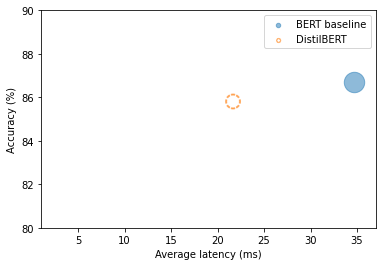

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

- The above is the performance of Distilbert when alpha is 1
- Optuna in Transformers, optimizes and finds the alpha and Temprature value

### Hyperparameter space that we wish to optimize

In [ ]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}


### Hyperparameter search
- we want the best possible accuracy, we specify direction="maximize" 
- The hyperparameter_search() method returns a BestRun object, which contains the value of the objective that was maximized (by default, the sum of all metrics) and the hyperparameters it used for that run:



In [ ]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)


[I 2022-11-06 21:12:14,926] A new study created in memory with name: no-name-010bf4cc-e354-4dfe-9330-6e793885b03c
Trial: {'num_train_epochs': 7, 'alpha': 0.6491595192268721, 'temperature': 14}
loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199937,0.591613
2,0.317300,0.099535,0.823548
3,0.317300,0.067820,0.882258
4,0.115100,0.053116,0.898710
5,0.076100,0.045661,0.910000
6,0.076100,0.042128,0.911290
7,0.062600,0.040738,0.912581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196479,0.583871
2,0.311700,0.098408,0.820323
3,0.311700,0.067362,0.881290
4,0.113600,0.052939,0.898387
5,0.075500,0.045633,0.909032
6,0.075500,0.042141,0.910645
7,0.062300,0.040773,0.911290


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.195262,0.583548
2,0.310000,0.097850,0.820645
3,0.310000,0.067131,0.881290
4,0.113100,0.052793,0.899355
5,0.075200,0.045511,0.908710
6,0.075200,0.042048,0.910645
7,0.062000,0.040686,0.911290


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.205837,0.578387
2,0.321300,0.107487,0.805806
3,0.321300,0.076884,0.870323
4,0.123800,0.064600,0.889355
5,0.088900,0.060979,0.893871


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.218409,0.612903
2,0.345400,0.105603,0.830968
3,0.345400,0.070040,0.885806
4,0.122500,0.053973,0.901613
5,0.079100,0.045932,0.912581
6,0.079100,0.042224,0.913548
7,0.064500,0.040758,0.913548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.415499,0.657742
2,0.645400,0.154585,0.834194
3,0.645400,0.080731,0.892581
4,0.176800,0.058187,0.907419
5,0.091100,0.049150,0.916452
6,0.091100,0.045271,0.920323
7,0.070900,0.043845,0.920968


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199937,0.591613
2,0.317300,0.099535,0.823548
3,0.317300,0.067820,0.882258
4,0.115100,0.053116,0.898710


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.218409,0.612903
2,0.345400,0.105603,0.830968
3,0.345400,0.070040,0.885806
4,0.122500,0.053973,0.901613
5,0.079100,0.045932,0.912581
6,0.079100,0.042224,0.913548
7,0.064500,0.040758,0.913548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.191835,0.592903
2,0.308000,0.092934,0.833871
3,0.308000,0.061929,0.888710
4,0.107900,0.046978,0.902581
5,0.068500,0.039136,0.915161
6,0.068500,0.034451,0.916129
7,0.053400,0.031313,0.921613
8,0.046400,0.029339,0.922258
9,0.046400,0.028244,0.921290
10,0.042900,0.027854,0.922581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194868,0.592903
2,0.311900,0.094975,0.829355
3,0.311900,0.063512,0.887097
4,0.110100,0.048466,0.901290
5,0.070500,0.040586,0.913548
6,0.070500,0.036046,0.914839
7,0.055600,0.033072,0.919677
8,0.049000,0.031468,0.920000


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.204989,0.613871
2,0.328800,0.096985,0.839355
3,0.328800,0.063228,0.892258
4,0.113000,0.047319,0.904839
5,0.070400,0.039053,0.916452
6,0.070400,0.034239,0.918710
7,0.054400,0.031059,0.923226
8,0.047100,0.029078,0.923548
9,0.047100,0.027968,0.924194
10,0.043600,0.027586,0.923548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.204989,0.613871
2,0.328800,0.096985,0.839355
3,0.328800,0.063228,0.892258
4,0.113000,0.047319,0.904839
5,0.070400,0.039053,0.916452
6,0.070400,0.034239,0.918710
7,0.054400,0.031059,0.923226
8,0.047100,0.029078,0.923548
9,0.047100,0.027968,0.924194
10,0.043600,0.027586,0.923548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.204989,0.613871
2,0.328800,0.096985,0.839355
3,0.328800,0.063228,0.892258
4,0.113000,0.047319,0.904839
5,0.070400,0.039053,0.916452
6,0.070400,0.034239,0.918710
7,0.054400,0.031059,0.923226
8,0.047100,0.029078,0.923548
9,0.047100,0.027968,0.924194
10,0.043600,0.027586,0.923548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.251758,0.639355
2,0.399500,0.110629,0.843548
3,0.399500,0.067324,0.893871
4,0.129300,0.049117,0.906452
5,0.076200,0.040269,0.918710
6,0.076200,0.035444,0.919032
7,0.058500,0.032457,0.924516
8,0.051100,0.030947,0.923871
9,0.051100,0.030469,0.925161


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407780,0.661935
2,0.639900,0.144018,0.839677
3,0.639900,0.073559,0.898710
4,0.166100,0.052474,0.912258
5,0.082600,0.043794,0.919032
6,0.082600,0.039282,0.926452
7,0.062200,0.036470,0.929032
8,0.054300,0.035142,0.928065
9,0.054300,0.034700,0.928387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407780,0.661935
2,0.639900,0.144018,0.839677
3,0.639900,0.073559,0.898710
4,0.166100,0.052474,0.912258
5,0.082600,0.043794,0.919032
6,0.082600,0.039282,0.926452
7,0.062200,0.036470,0.929032
8,0.054300,0.035142,0.928065
9,0.054300,0.034700,0.928387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-15/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407780,0.661935
2,0.639900,0.144018,0.839677
3,0.639900,0.073559,0.898710
4,0.166100,0.052474,0.912258
5,0.082600,0.043794,0.919032
6,0.082600,0.039282,0.926452
7,0.062200,0.036470,0.929032
8,0.054300,0.035142,0.928065
9,0.054300,0.034700,0.928387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-16/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.234461,0.631290
2,0.371800,0.108102,0.839032
3,0.371800,0.068658,0.890645


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2022-11-06 22:02:14,759] Trial 17 pruned. 
Trial: {'num_train_epochs': 8, 'alpha': 0.1759134712756465, 'temperature': 4}
loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.253563,0.635806
2,0.400800,0.113042,0.840968
3,0.400800,0.069536,0.892903
4,0.131800,0.051314,0.905806
5,0.079000,0.042442,0.916129


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-18/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.222077,0.624194
2,0.353800,0.103018,0.841935
3,0.353800,0.065969,0.891613


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2022-11-06 22:05:02,971] Trial 19 pruned. 


In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.209574,0.742258
2,1.518200,0.605776,0.856774
3,1.518200,0.359852,0.914839
4,0.561900,0.273186,0.930968
5,0.283700,0.243344,0.938387
6,0.283700,0.230991,0.940968
7,0.217000,0.224044,0.942903
8,0.195900,0.221106,0.942258
9,0.195900,0.220101,0.942258


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-1000
Configuration saved in distilbert-base-uncased-distilled-clinc/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in d

### Benchmarking Our Distilled Model


In [ ]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())


Downloading:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/config.json
Model config DistilBertConfig {
  "_name_or_path": "transformersbook/distilbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": "what_are_your_hobbies",
    "16": "order",
    "17": "jump_start",
    "18": "schedule_meeting",
 

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at transformersbook/distilbert-base-uncased-distilled-clinc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--transformersbook--distilbert-base-uncased-distilled-clinc/snapshots/0bebc777ca5e752414f583b61261b102ca45c606/tokenizer_config.json


Model size (MB) - 255.89
Average latency (ms) - 18.09 +\- 1.72
Accuracy on test set - 0.868


In [ ]:
plot_metrics(perf_metrics, optim_type)